# LAB 4: ANALYZING NETWORK DATA LOG

In [109]:
%pip install ipwhois
%pip install networkx

import pandas as pd
import numpy as np
from ipwhois import IPWhois
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px


In [110]:
# Define column format as per Table 1 in the manual
# There is an extra comma leading to a csv with 1 additional column
format = ['Type', 'sflow_agent_address', 'inputPort', 'outputPort',
        'src_MAC', 'dst_MAC', 'ethernet_type', 'in_vlan', 'out_vlan',
        'src_IP', 'dst_IP', 'IP_protocol', 'ip_tos', 'ip_ttl',
        'udp_src_port', 'udp_dst_port', 'tcp_flags',
        'packet_size', 'IP_size', 'sampling_rate', 'extra']


# Read CSV file
log_df = pd.read_csv('Data_2.csv', header=None, names=format)

# Remove extra blank column
log_df.drop('extra', axis=1, inplace=True)

"""
# List of columns should be int
cols_to_int = ['IP_protocol', 'out_vlan', 'udp_src_port', 'udp_dst_port', 'packet_size', 'IP_size', 'sampling_rate']
for c in cols_to_int:
    log_df[c] = pd.to_numeric(log_df[c], errors='coerce')

log_df[cols_to_int] = log_df[cols_to_int].fillna(0).astype(int)
"""

# Preview first 10 rows
log_df.head(10)

,Type,sflow_agent_address,inputPort,outputPort,src_MAC,dst_MAC,ethernet_type,in_vlan,out_vlan,src_IP,dst_IP,IP_protocol,ip_tos,ip_ttl,udp_src_port,udp_dst_port,tcp_flags,packet_size,IP_size,sampling_rate
0,FLOW,203.30.38.251,193,130,0031466b23cf,00239cd087c1,0x0800,919.0,919,74.125.10.59,137.132.38.238,17,0x00,63,443.0,62758,0x00,1396,1378,2048
1,FLOW,203.30.38.251,193,130,0031466b23cf,00239cd087c1,0x0800,919.0,919,173.194.22.215,137.132.228.29,6,0x00,63,443.0,39740,0x10,1438,1420,2048
2,FLOW,203.30.38.251,199,131,544b8cf9a7df,001cb0c88e40,0x0800,600.0,43,193.62.193.9,202.130.56.153,6,0x00,246,80.0,35794,0x18,272,250,2048
3,FLOW,203.30.38.251,193,131,0031466b23cf,001cb0c88e40,0x0800,919.0,43,74.125.130.132,192.122.131.33,6,0x00,52,443.0,5287,0x10,1418,1400,2048
4,FLOW,203.30.38.251,129,193,00135f21bc80,0031466b23cf,0x0800,11.0,919,155.69.160.69,74.125.68.139,17,0x60,59,48361.0,443,0x00,89,67,2048
5,FLOW,203.30.38.251,135,129,002688cd5fc7,00135f21bc80,0x0800,919.0,11,54.230.159.64,155.69.191.254,6,0x00,251,443.0,16657,0x10,1418,1400,2048
6,FLOW,203.30.38.251,129,193,00135f21bc80,0031466b23cf,0x0800,11.0,919,155.69.253.4,74.125.10.39,6,0x00,63,51374.0,443,0x10,74,52,2048
7,FLOW,203.30.38.251,129,193,00135f21bc80,0031466b23cf,0x0800,11.0,919,155.69.160.73,64.233.188.128,6,0x00,56,23153.0,443,0x10,1422,1400,2048
8,FLOW,203.30.38.251,200,130,80711fc76001,00239cd087c1,0x0800,280.0,919,129.99.230.54,137.132.22.74,6,0x00,53,48975.0,15000,0x10,1442,1420,2048
9,FLOW,203.30.38.251,200,129,80711fc76001,00135f21bc80,0x0800,280.0,11,210.32.0.65,155.69.16.255,6,0x00,41,80.0,56552,0x10,1522,1500,2048


# Exercise 4A: Top Talkers and Listeners

In [111]:
# Find organizations name based on IP address
def find_org(ip):
    ip = IPWhois(ip)
    result = ip.lookup_rdap()
    return result.get('network', {}).get('name')

In [112]:
# Find top 5 talkers (source IPs with most packets sent)
top_talkers = log_df['src_IP'].value_counts().nlargest(5).to_frame()

# Lookup organisation names
org = []
for ip in top_talkers.index:
    org.append(find_org(ip))

# Add organisation info to DataFrame
top_talkers['Organisations'] = org
top_talkers = top_talkers.reset_index().rename(columns = {'src_IP':'IP Address',
                                                        'count':'# of packets'})
top_talkers



,IP Address,# of packets,Organisations
0,13.107.4.50,5960,MSFT
1,130.14.250.7,4034,NLM-ETHER
2,155.69.160.38,3866,NTUNET1
3,171.67.77.19,2656,NETBLK-SUNET
4,155.69.199.255,2587,NTUNET1


In [113]:
# Find top 5 listeners (destination IPs with most packets received)
top_listener = log_df['dst_IP'].value_counts().nlargest(5).to_frame()

# Lookup organisations
org = []
for ip in top_listener.index:
    org.append(find_org(ip))

# Add organisation info
top_listener['Organisations'] = org
top_listener = top_listener.reset_index().rename(columns = {'dst_IP':'IP Address',
                                                        'count':'# of packets'})
top_listener

,IP Address,# of packets,Organisations
0,137.132.228.33,5908,NUSNET
1,192.122.131.36,4662,A-STAR-AS-AP
2,202.51.247.133,4288,NUSGP
3,137.132.228.29,4022,NUSNET
4,103.37.198.100,3741,A-STAR-AS-AP


# Exercise 4B: Transport Protocol

In [114]:
packet_df = log_df['IP_protocol'].value_counts().to_frame()
packet_df = packet_df.reset_index().rename(columns={'IP_protocol':'Header Value',
                                                    'count':'# of packets'})

# Calculate protocol percentages
percentage = []
for i in range(len(packet_df)):
    percentage.append(packet_df['# of packets'][i] * 100 / len(log_df))

packet_df['Percentage'] = percentage
packet_df

,Header Value,# of packets,Percentage
0,6,137707,77.698723
1,17,36852,20.793085
2,0,1216,0.686106
3,50,718,0.405119
4,47,664,0.374650
5,1,60,0.033854
6,58,10,0.005642
7,41,3,0.001693
8,2,2,0.001128


In [115]:
# Given IP_Protocol 6 = TCP, IP_Protocol 17 = UDP
tcp_packet_df = packet_df.loc[packet_df['Header Value'] == 6]
udp_packet_df = packet_df.loc[packet_df['Header Value'] == 17]
frames = [tcp_packet_df, udp_packet_df]
final_df = pd.concat(frames)
final_df

,Header Value,# of packets,Percentage
0,6,137707,77.698723
1,17,36852,20.793085


# Exercise 4C: Application Protocol

In [116]:
# Top 5 destination ports
dest_port_df = log_df['udp_dst_port'].value_counts().nlargest(5).to_frame()
dest_port_df = dest_port_df.reset_index().rename(columns={'udp_dst_port':'Destination IP port number',
                                                          'count':'# of packets',})
dest_port_df

,Destination IP port number,# of packets
0,443,43208
1,80,11018
2,50930,2450
3,15000,2103
4,8160,1354


# Exercise 4D: Traffic

In [119]:
# Sum up the total IP data size in bytes
total_traffic = sum(log_df['IP_size'])

# bytes → MB
total_traffic_MB = total_traffic / (2**20)

# Multiply sampling rate (2048) to get total real traffic
total_traffic_MB *= 2048

print(f"Total Traffic (MB) = {total_traffic_MB:.3f} MB")

Total Traffic (MB) = 331903.809 MB


# Exercise 4E: Additional Analysis


# 1. Top 10 communication pairs

In [120]:
# Top 10 unique communication pairs
unique_comm_pairs_df = (
    log_df.groupby(['src_IP', 'dst_IP'])
    .size()
    .sort_values(ascending = False)
    .to_frame(name = '# of packets')
    .reset_index()
)

# Select top 10 pairs
top_comm_df = unique_comm_pairs_df.head(10)
top_comm_df

# Lists for organisation lookups
src_org = []
dst_org = []

for i in range(10):
    src_org.append(find_org(top_comm_df['src_IP'][i]))
    dst_org.append(find_org(top_comm_df['dst_IP'][i]))

top_comm_df['Source Organisation'] = src_org
top_comm_df['Destination Organisation'] = dst_org

top_comm_df = top_comm_df.reindex(
    columns = [
        'src_IP',
        'Source Organisation',
        'dst_IP',
        'Destination Organisation',
        '# of packets'
    ]
)

# Display
top_comm_df

/tmp/ipython-input-1730172825.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_comm_df['Source Organisation'] = src_org
/tmp/ipython-input-1730172825.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_comm_df['Destination Organisation'] = dst_org


,src_IP,Source Organisation,dst_IP,Destination Organisation,# of packets
0,130.14.250.7,NLM-ETHER,103.37.198.100,A-STAR-AS-AP,3739
1,171.67.77.19,NETBLK-SUNET,192.122.131.36,A-STAR-AS-AP,2656
2,129.99.230.54,NAS-NET,137.132.22.74,NUSNET,2097
3,137.132.228.42,NUSNET,137.131.17.212,ORACLE-4,1553
4,155.69.252.133,NTUNET1,138.75.242.36,M1LIMITED-SG,1475
5,13.107.4.50,MSFT,210.48.222.13,IIUM-MY,1289
6,155.69.203.215,NTUNET1,74.125.10.7,GOOGLE,1257
7,192.170.233.203,UOC-NET3,202.6.241.101,A-STAR-NET,1196
8,202.21.159.246,RPNET,104.146.199.27,O365,1143
9,155.69.59.250,NTUNET1,175.156.89.102,M1Net,1068


## 2. Visualize Network Connections

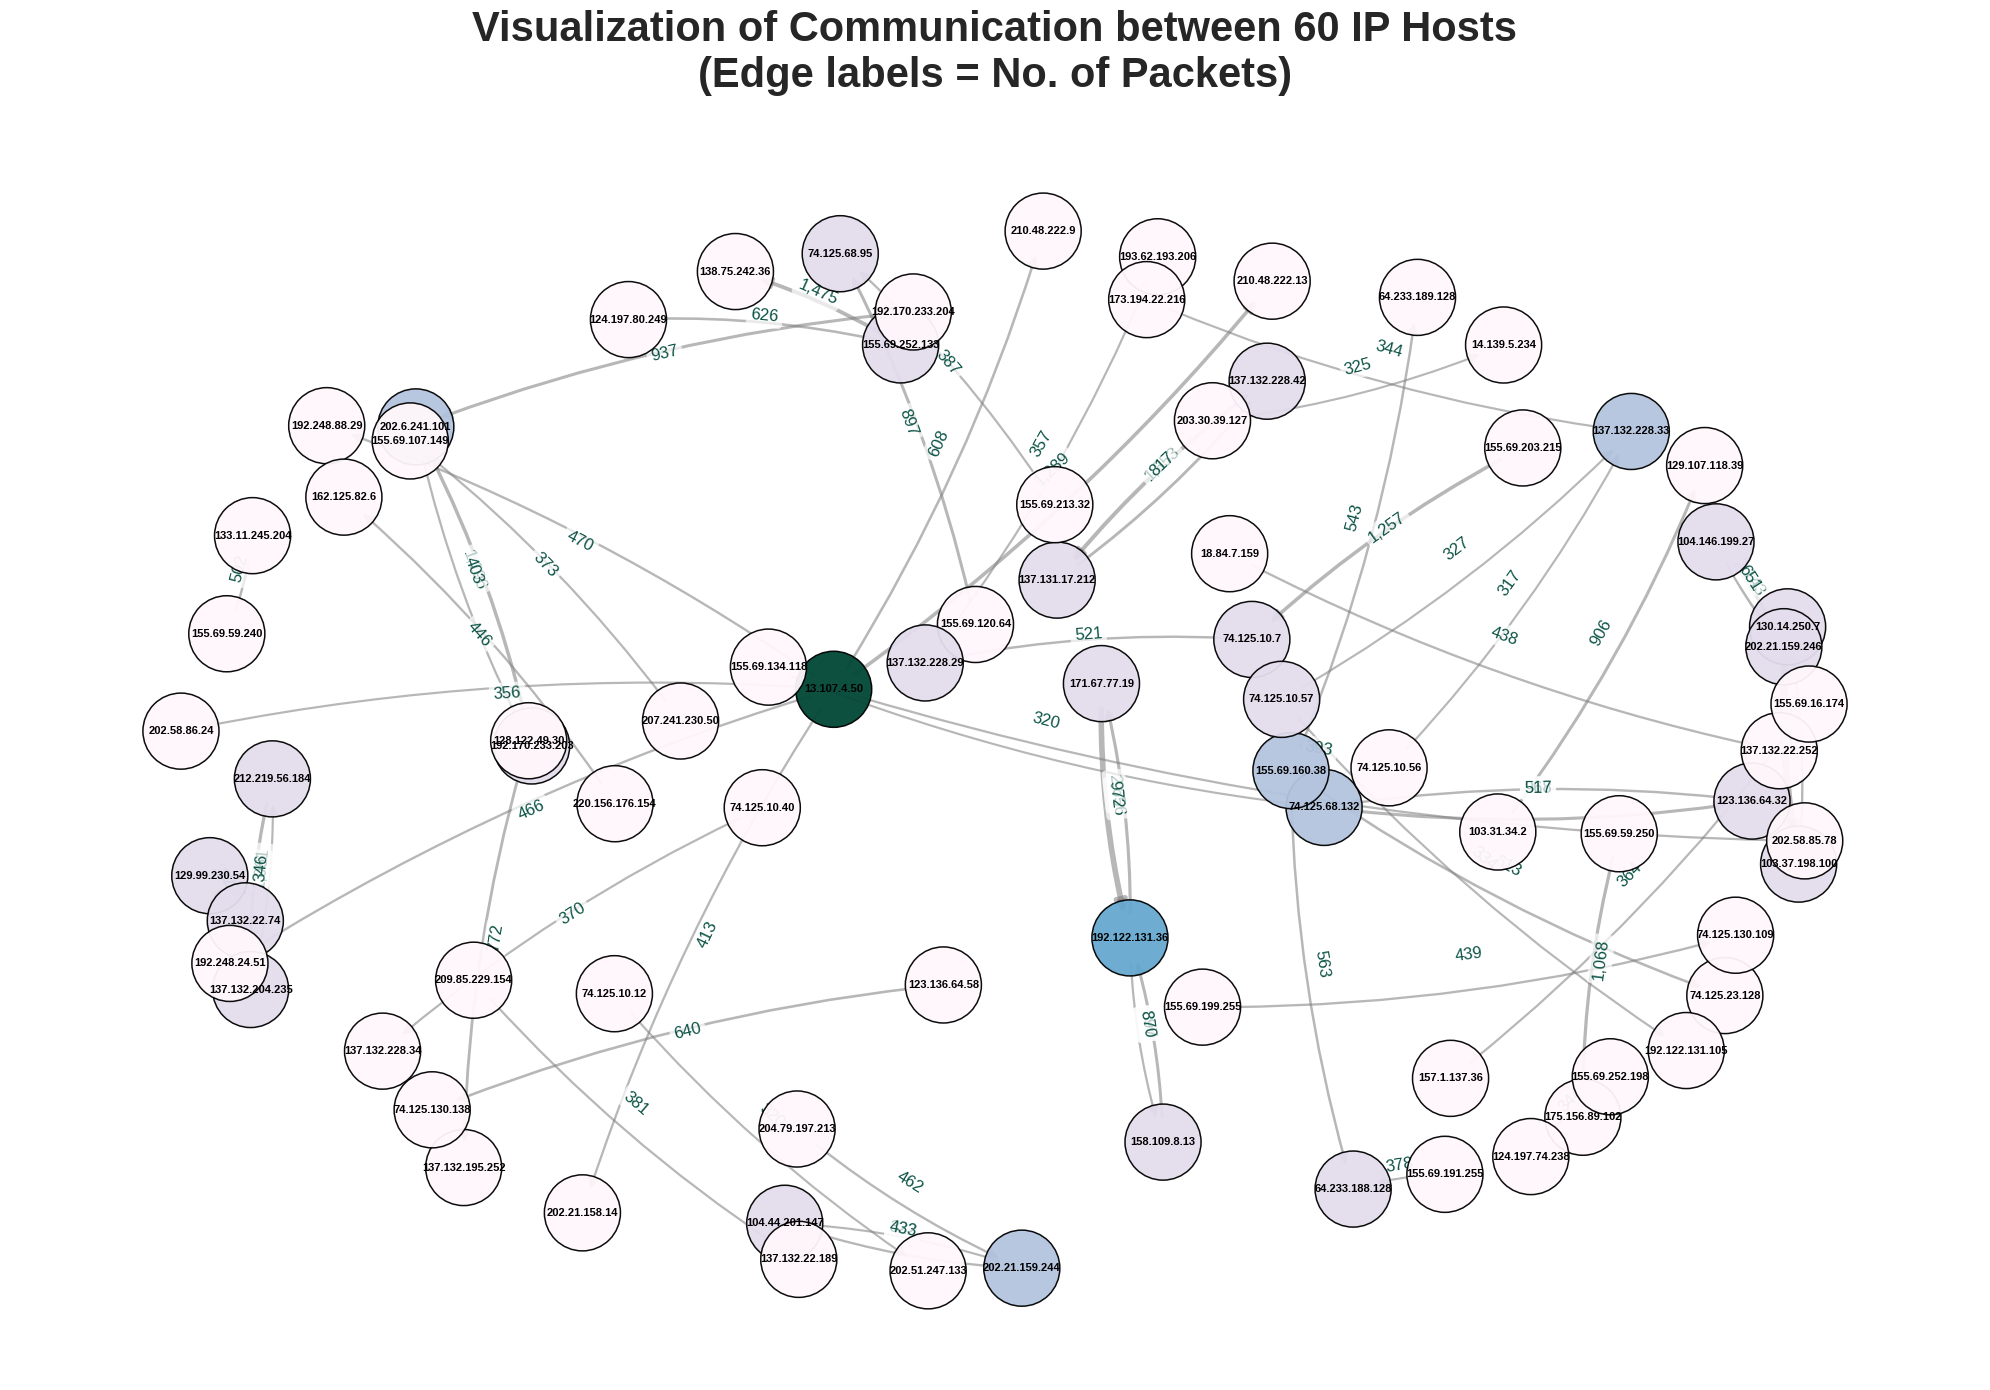

In [ ]:
# Top 60 communication pairs
subset_df = unique_comm_pairs_df.head(60)

# Directed graph with packet count
net = nx.from_pandas_edgelist(
    subset_df,
    source = "src_IP",
    target = "dst_IP",
    edge_attr = "# of packets",
    create_using = nx.DiGraph()
)

plt.figure(figsize = (20, 14))
plt.style.use("seaborn-v0_8-whitegrid")

# Layout
layout = nx.spring_layout(net, k = 1.3, iterations = 140, seed = 24)

# Node size
fixed_node_size = 3000

# Compute packet weights
edges = net.edges()
weights = [net[u][v].get("# of packets", 1) for u, v in edges]
max_w = max(weights) if weights else 1

# Compute degree centrality for coloring
centrality = nx.degree_centrality(net)
color_values = [centrality[node] for node in net.nodes()]

# Draw network edges
nx.draw_networkx_edges(
    net, layout,
    edge_color = "#7D7D7D",
    alpha = 0.55,
    arrows = True,
    arrowsize = 16,
    width = [1.2 + (w / max_w) * 4 for w in weights],
    connectionstyle = "arc3,rad=0.07",
    min_source_margin = 18,
    min_target_margin = 18
)

# --- Draw nodes (teal–purple gradient instead of yellow–red) ---
nx.draw_networkx_nodes(
    net, layout,
    node_size = fixed_node_size,
    node_color = color_values,
    cmap = "PuBuGn",    # distinct color map
    edgecolors = "black",
    linewidths = 1.1,
    alpha = 0.95
)

# Add IP address labels
nx.draw_networkx_labels(
    net, layout,
    font_size = 8,
    font_color = "black",
    font_weight = "semibold"
)

# Create and draw edge labels (packet counts)
edge_labels = {(u, v): f"{net[u][v]['# of packets']:,}" for u, v in net.edges()}
label_pos = {n: (x, y + 0.03) for n, (x, y) in layout.items()}

nx.draw_networkx_edge_labels(
    net, label_pos,
    edge_labels = edge_labels,
    font_size = 12,
    font_color = "#0B5345",  # dark green
    bbox = dict(boxstyle = "round,pad=0.25", facecolor = "white", alpha = 0.7, edgecolor = "none")
)

plt.title(
    "Visualization of Communication between 60 IP Hosts\n(Edge labels = No. of Packets)",
    fontsize = 30,
    fontweight = "bold",
    pad = 25
)
plt.axis("off")
plt.tight_layout()
plt.show()